<a href="https://colab.research.google.com/github/itberrios/CV_projects/blob/main/mars_challenge/camera_motion_compensation_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Camera Motion Compensation**

### **What is Camera Motion Compensation?**
Camera Motion Compensation (or CMC) aims to describe the relative motion of one frame to the next. We can do this with something called a Rigid Body Transformation, which is nothing more than a translation combined with a rotation in the x-y plane.

In this notebook we will learn about camera motion compensation (CMC). In CMC, the objective is to describe the relative motion of a camera between two consecutive image frames. We can describe this motion through something called a Rigid Body Transformation, which is nothing more than a translation plus a rotation in the x-y plane. NOTE: A Rigid Body Transformation is an Affine transformation, meaning that it preserves points, straight lines, and planes.

### **How do we get the Rigid body (Affine) Transformation?**
We can get the Rigid Body Transformation by finding points of interest in the previous frame and comparing their location in the current frame. We can find by the points of interest with something called corner detection (Shi-Thomasi, Harris, FAST, etc). We can find the locations of the points on the current frame with Sparse Optical Flow, in this case we will use Lucas-Kanande Optical Flow.

Once we have the points in both the previous and current frames, we can then compute the Rigid Body Transformation Matrix, a 2x3 matrix.  We will use the opencv function estimateAffinePartial2D() to do this. It will estiamte the optimal affine transformation between both sets of points. This will give us our resulting affine transformation that we have been looking for.

### **What can we do with camera motion compensation?**
- Improve Visual Trackinh accuracy with a moving camera
- Estimate speed of moving camera


### **Download the data!**

In [ ]:
!wget https://marschallenge.s3.ap-northeast-2.amazonaws.com/train.mp4

### **Import Libraries**

In [2]:
import os
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt

%matplotlib inline

#### Load part of train video into memory

In [47]:
cap = cv2.VideoCapture("train.mp4")

if (cap.isOpened() == False):
    print("Error opening video file")

frames = []
i = 0
while(cap.isOpened()):

    # read each video frame
    ret, frame = cap.read()

    if ret == True:
        image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frames.append(image)

        if i == 2000:
            break
        else:
           i += 1

    # Break if nothing is returned
    else:
        break

# clean up
cap.release()
cv2.destroyAllWindows()

In [48]:
len(frames)

2001

In [49]:
frame1 = frames[1000]
frame2 = frames[1001]

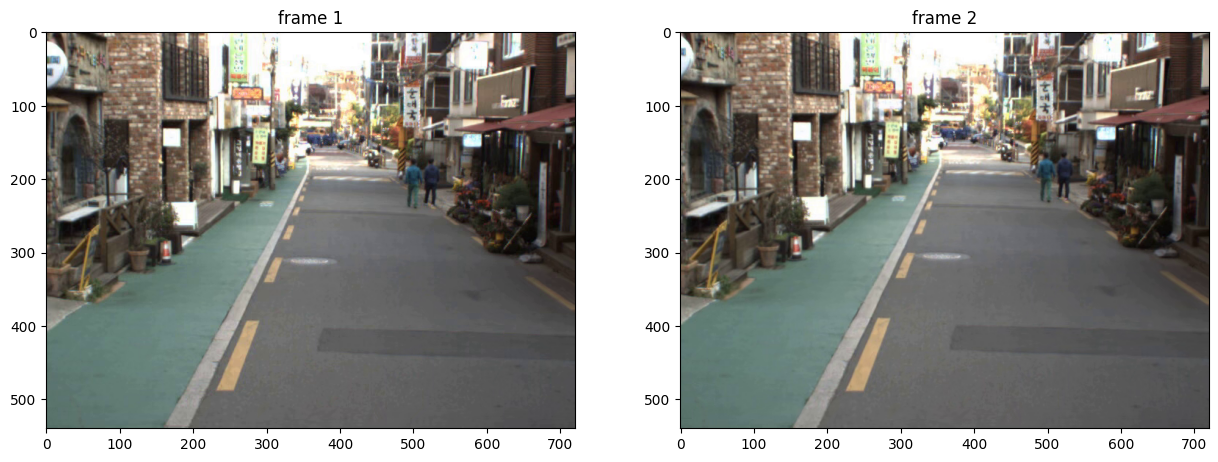

In [50]:
_, ax = plt.subplots(1, 2, figsize=(15,15))
ax[0].imshow(frame1)
ax[0].set_title("frame 1")
ax[1].imshow(frame2)
ax[1].set_title("frame 2");

In [81]:
gray1 = cv2.cvtColor(frame1, cv2.COLOR_RGB2GRAY)
gray2 = cv2.cvtColor(frame2, cv2.COLOR_RGB2GRAY)

In [82]:
corners = cv2.goodFeaturesToTrack(gray1, 100, qualityLevel=0.01, minDistance=10)

We will use the FAST corner detector. It is not as Robust as Shi-Tomasi, but it will get us most of the features/keypoints most of the time at a very fast speed. It turns out that we really only need #### number of keypoints to accuratley compute the translation and rotation between frames.

In [83]:
frame1_copy = frame1.copy()
for i in corners.astype(int):
  x,y = i.ravel()
  cv2.circle(frame1_copy, (x,y), 5, (255, 0, 0), -1)

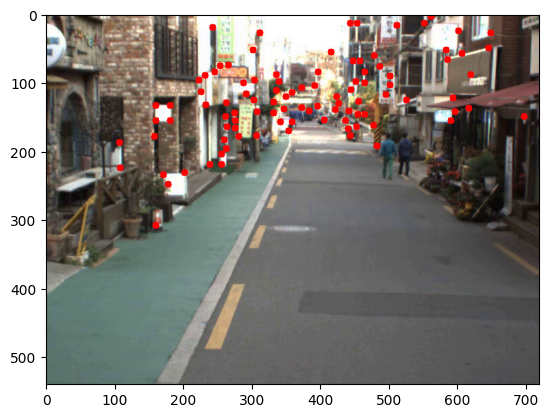

In [84]:
plt.imshow(frame1_copy, cmap='gray')

In [85]:
matched_corners, status, error = cv2.calcOpticalFlowPyrLK(gray1, gray2, corners, None)

In [86]:
matched_corners.shape

(100, 1, 2)

In [87]:
status = status.reshape((-1))

In [88]:
prev_points = corners.reshape((-1, 2))[status]
curr_points = matched_corners.reshape((-1, 2))[status]

In [89]:
A, _ = cv2.estimateAffinePartial2D(prev_points, curr_points, method=cv2.RANSAC)

In [91]:
A

array([[ 1.00832172e+00,  5.26935058e-03, -5.61726431e+00],
       [-5.26935058e-03,  1.00832172e+00, -7.60121952e+00]])

In [94]:
gray1.shape

(540, 720)

In [101]:
# transform previous frame to current frame position
transformed_1 = cv2.warpAffine(frame1, A, dsize=(gray1.shape[::-1]))
transformed_1_gray = cv2.warpAffine(gray1, A, dsize=(gray1.shape[::-1]))

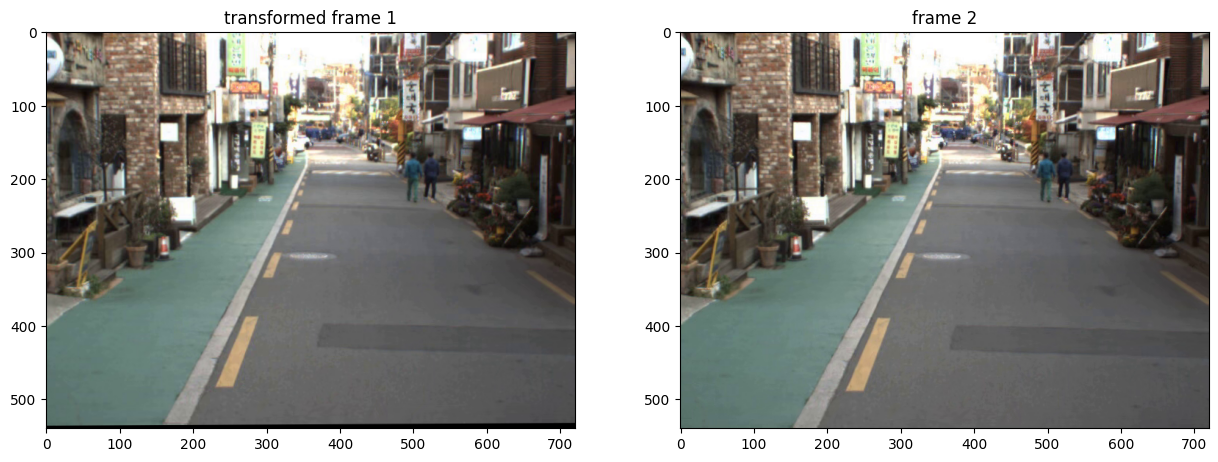

In [98]:
_, ax = plt.subplots(1, 2, figsize=(15,15))
ax[0].imshow(transformed_1)
ax[0].set_title("transformed frame 1")
ax[1].imshow(frame2)
ax[1].set_title("frame 2");

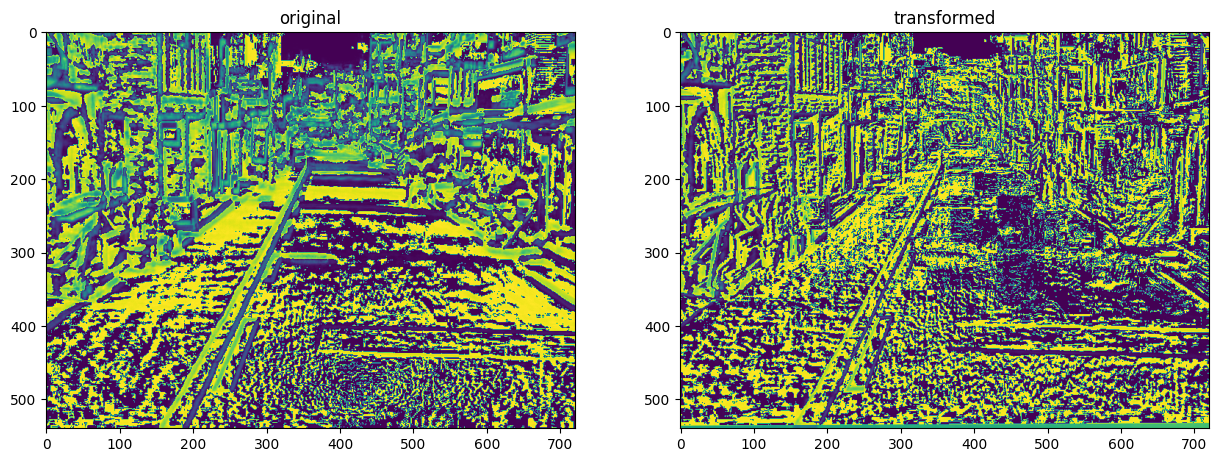

In [102]:
_, ax = plt.subplots(1, 2, figsize=(15,15))
ax[0].imshow(gray1 - gray2)
ax[0].set_title("original")
ax[1].imshow(transformed_1_gray - gray2)
ax[1].set_title("transformed");

In [103]:
np.mean(gray1 - gray2), np.mean(transformed_1_gray - gray2)

(121.94808899176955, 116.31819444444444)

In [104]:
np.median(gray1 - gray2), np.median(transformed_1_gray - gray2)

(90.0, 19.0)

In [105]:
np.std(gray1 - gray2), np.std(transformed_1_gray - gray2)

(112.30854512835631, 121.36326864231432)

# **References**

- https://arxiv.org/pdf/2003.12039.pdf
- https://docs.opencv.org/3.4/dd/d1a/group__imgproc__feature.htmhttps://www.mathworks.com/discovery/affine-transformation.html